# BIRCH (__B__alanced __I__terative __R__educing and __C__lustering using __H__ierarchies)

## Prerequisits

+ Understanding of agglomerative hierarchical clustering

## Objectives

After completing this chapter, student will be able to

+ Describe the scalability of various clustering algorithm

+ Explain clustering feature (CF) and CF-tree

+ Explain the methodology of insertion into the CF-tree

+ Explain the phases of BIRCH algorithm and identify the steps of each phases

+ Point out at least three advantages and at least two disadvantages of BIRCH algorithm

+ Implement BIRCH algorithm using `sklearn` .


## Introduction

When we have a large data to cluster, most of the traditional clustering algorithm does not scale well; the computation resource required to perform those algorithm is high. The algorithms we studied in the previous chapter does not solve this issue. BIRCH can be used when the data set is large and the cost of I/O is high. BIRCH can perform the clustering operation with just a single scan of the dataset. Furthermore, the quality of clusters can be increased by few additional scan of the data set. BIRCH can also handle the noise or outliers present in the dataset in an effective way. But, BIRCH only works for metric data type which is a data type that can be represented as a coordinate in euclidian space.

To achieve the efficiency, BIRCH uses a new data structure called clustering feature (CF) and CF tree. You are going to learn about those in detail below. In summary, BIRCH creats a balanced CF tree which is a compact tree structure that represents the clusters of data.


## Clustering Feature (CF)

Clustering Feature (CF) is an important concept in BERCH algorithm, so let's learn about it. A clustering feature is a triple summarizing the information about a cluster. So, if we have a cluster $\mathcal A$, then a single clustering feature would be able to summarize relevant information about $\mathcal A$.

Let's assume we have a cluster containing $n$ number of d-dimensional data points given as $C = \{\mathbf x_1, \dots, \mathbf x_n\}$ where $\mathbf x_i \in \mathbb R^d$. Then the clustering feature (CF) vector of that cluster is defined as a triple,
$$
\begin{align}
CF &= (N, LS, SS)
\end{align}
$$
Where,

N is the number of elements in the cluster. In this case $N = n$. $LS$ is the linear sum of $N$ data points given as,
$$
LS = \sum_{i=1}^N \mathbf x_i
$$

And the $SS$ is the squared sum of N data points given as,
$$
SS = \sum_{i=1}^N \mathbf x_i^2
$$

### Additive property of CF

If we have two disjoint clusters given in the form of CF as,
$$
CF_1 = (N_1, LS_1, SS_1) \hspace{1cm}\text{and}\hspace{1cm} CF_2 = (N_2, LS_2, SS_2)
$$

Now, if we merge those two cluster to form a new cluster $C_m$, then the cluster feature of the new cluster $CF_m$ can be calculated as,
$$
CF_m = (N_1 + N_2, LS_1 + LS_2, SS_1 + SS_2)
$$

This is a very important feature of clustering feature because now we can store the clustering feature and calculate the clustering feature of merged cluster incrementally and accurately. In the previous chapter you saw the cluster as a set of data points, but in BIRCH the clusters are sequence of set of cluster feature which contains only the summary information about the data. CF feature allows us to calculate various similarity (or dissimilarity) measurements and also gives us a light size version of data to work around. If we have a large dataset, you can see that converting those to cluster feature would make it lightweight allowing us to process it inmemory.


## CF Tree

CF tree is a height-balanced tree that has two parameters namely a branching factor represented by $B$ and the threshold represented by $T$. The parameter $B$ and $T$ controls the size of the tree. The branching factor $B$ is the maximum number of entries for a non-leaf node. If $N_1$ is a non-leaf node, then it is represented in the following form,
$$
N_1 = [CF_i, child_i],\ where\ i=1,\dots,B
$$

Where, $child_i$ represents the pointer to its $i^{th}$ child node and $CF_i$ is the cluster feature of the sub-cluster represented by this child.

The parameter $T$ on the other hand controls the diameter (or radius) of the entries at leaf node.

+ Diameter of a cluster

> Diameter of a cluster is defined as the average pairwise distance within a cluster. If we have $n$ number of entries in a cluster given as $\{x_1,\dots,x_n\}$, then the diameter is calculated as,

$$
D = \sqrt{\frac{\sum_{i=1}^n\sum_{j=1}^n (x_i - x_j)^2}{n(n-1)}}
$$

+ Radius of a cluster

> Radius of a cluster is defined as the average distance from member object to its centroid.
>
> If $c$ is the centroid of the above dataset given as,
$$
c = \frac{1}{n} \sum_{i=1}^n x_i
$$
>
> The radius can be written as,
$$
R = \sqrt{\frac{\sum_{i=1}^n(x_i - c)^2}{n}}
$$

So, with the parameter $T$ we have,
$$
D \lt T \hspace{1cm}or,\hspace{1cm} R \lt T
$$

As you can see, having larger value of threshold, $T$ allows more entries for leaf nodes making the tree smaller and vice-versa.

A leaf node contains at most $L$ entries, so if $L_1$ is the leaf node then it can be represented as,
$$
L_1 = [CF_i],\ where\ i = 1,\dots,L
$$

The leaf node also contains two pointers namely "prev" and "next" that is used to chain all the leaf nodes together for efficient scans.

The tree is created dynamically as a new data point is inserted. CF tree helps us in the insertion of new data point to a correct subcluster. The structure of CF-tree is similar to that of B+-tree which is used for the purpose of sorting. Also, CF-tree is a compact representation of the dataset. In the following section, you will understand the insertion process in the CF-tree in detail.


There are four steps in the BIRCH algorithm to insert a new data in *CF*-Tree. They are listed and described below sequentially.

1. Identifying the appropriate leaf node

> When a new data point is to be inserted, we have to find the closest leaf node to this data point. Various distance measure can be used to select the closest leaf. The indentification of leaf node follows the following process:
>
> a. Set current node to root node
> 
> b. Find the next closest child node and set it to current node
> 
> c. Repeat step-b until current node is a leaf node


2. Modifying the leaf

> After reaching a leaf node say $L$, find the closest leaf entry say $L_i$. Then test whether $L_i$ can absorb the new data without violating the threshold contition.
>
> If it does not violet the condition, then update the CF vector for $L_i$ to reflect the merge. Otherwise, a new entry for the new data point is added to the leaf node.
>
> Now, if there was the space required in the leaf node, then we are done and proceed to the next point. Otherwise, we have to split the leaf node. For the split, we choose a pair of points that are farthest apart as a seed. Then we redistribute remaining data based on the closest criterion (assign to the one that is closest).


3. Modifying the path to the leaf

> Once the new data point is inserted into the leaf node, we must update the cluster feature vector for all the non-leaf node along the path to this leaf node.
>
> If there was no split in the leaf node, then a simple update of CF vectors would be sufficient.
>
> The leaf split require us to insert a new non-leaf entry into the parent node to describe the newly created leaf node. If the split has the space for this entry, then we only need to update the CF vectors to reflect the addition of new data.
>
> If the split did not have the space, we have to split the parent and so on until we reach the root node. If the root node is splitted, the height of the tree increases by one.

4. A Merging Refinement

> As we know, the splitting is caused solely by the size of clusters rather than the properties of data. With a certain type of data input, the quality of the cluster can degrade with the split. To ameliorate this problem, extra merging steps are carried.



The BIRCH algorithm can be divided into four phases where phase-2 and phase-4 are optional, so normally it consists of two phases. The phases of Birch are shown in the figure below.

<div align="center">
    <figure>


<p>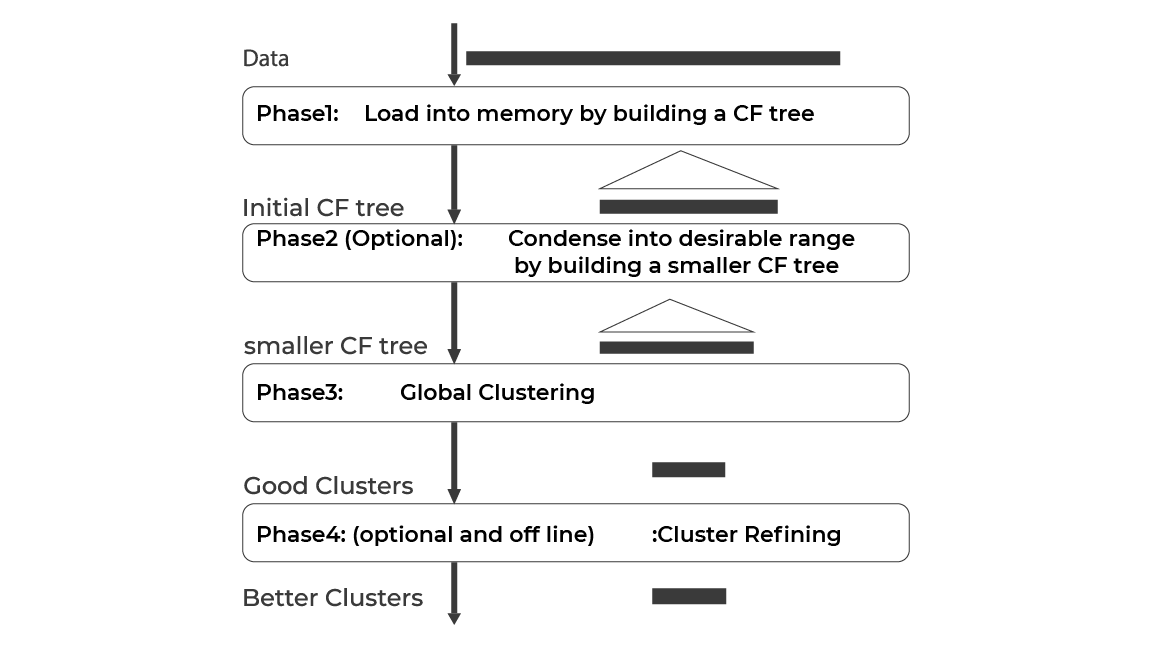</p>
        <figcaption>Figure 1: Phases of BIRCH algorithm. (src: <a href="https://dsf.berkeley.edu/cs286/papers/birch-sigmod1996.pdf">Birch Overview</a> by ZHang et al.)</figcaption>
    </figure>
</div>

Now, lets understand each step one by one.

1. Phase 1

    Phase-1 is about scanning the data and creating the in-memory CF tree using the given amount of memory. The CF tree tries to reflect the clustering information as accurately as possible. In this phase, the outliers are also removed to a certain degree. With the in-memory CF tree,
    
    a. The memory requirement is reduced because CF tree are summary of data

    b. Fast operation because the no I/O operations are required

2. Phase 2

    The phase 2 of BIRCH is optional. In this phase, we try to condense the CF tree from phase 1 by merging two subgroup into a larger one and removing the remaining outliers.

3. Phase 3

    In this phase we use either global or semi-global algorithm to cluster all the leaf entries. We can take following approaches to cluster the leaf nodes:

    a. Naive approch: use centroid as the representation of each clusters then use existing algorithm.

    b. Take the number of data points in a cluster into account. In simple term, instead of taking the naive centroid, we can take the weighted centroid.

    c. As we know, we can calculate most of the pointwise distance from the CF vectors. So, one of the strategy is to apply a distance function directly to the CF vectors of sub-clusters.

    In the original paper, the authors used agglomerative hierarchical clustering algorithms by applying them directly on the CF vectors.

4. Phase 4

    Phase 4 is used to fix some of the misplacement of data. This phase is also optional and adds the computation cost required to correct the misplacement and also further refinement of clusters.

    We can take the centroid of the clusters produced from phase 3 as a seed. Then assign the data points to the closest seed to obtain a set of new clusters. If we had a misplacement of a data point, that can be solved by this process and also make the same copy of data to belong in same cluster if it exists. This phase also provides us the option to discard the outliers where the outliers can be those point that lies far away from the nearest centroid.


## Implementation Example


We are going to use few synthetic dataset and visualize the result of BIRCH clustering on them. Remember that the true power of BIRCH comes when the dataset at hand is quite large than the available memory. But, for simplicity we will use a small dataset and see the algorithm at work.

We will use the [BIRCH](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html) from `sklearn`  for this task.


### Synthetic dataset

Let's synthesise a dataset using the [`make_blobs`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function from `sklearn`.


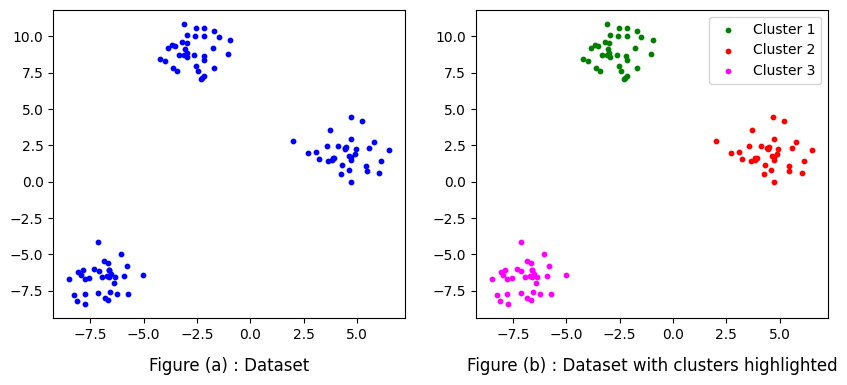

In [4]:
# Import for plotting purposes
import matplotlib.pyplot as plt

# import the make_blobs function
from sklearn.datasets import make_blobs

# number of data points
N = 100

X, y = make_blobs(n_samples=N, n_features=2, random_state=42)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the dataset without labels
ax1.scatter(X[:, 0], X[:, 1], s=10, c='blue')
ax1.set_title('Figure (a) : Dataset', y=-0.2)

# Plot the dataset with labels
colors = ['green', 'red', 'magenta']
for i in set(y):
    X_i = X[y==i]
    ax2.scatter(X_i[:, 0], X_i[:, 1], s=10, c=colors[i], label=f'Cluster {i+1}')
ax2.set_title('Figure (b) : Dataset with clusters highlighted', y=-0.2)
ax2.legend()

plt.show()

### BIRCH Algorithm

Now, let's import and apply the BIRCH algorithm for the synthetic dataset from above.


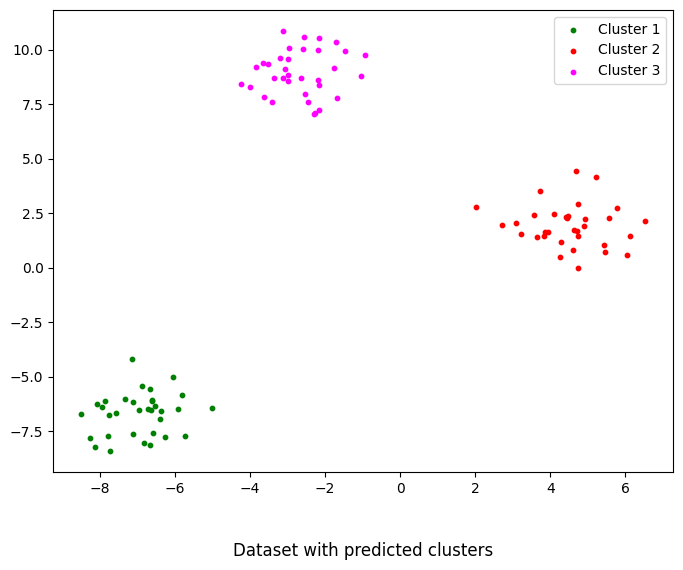

In [3]:
# import the BIRCH class
from sklearn.cluster import Birch

model = Birch()

# fit the model
model.fit(X)

labels = model.labels_

# Plot the true labels and predicted labels
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

colors = ['green', 'red', 'magenta']

# Plot the dataset with predicted labels
for i in set(labels):
    X_i = X[labels==i]
    ax.scatter(X_i[:, 0], X_i[:, 1], s=10, c=colors[i], label=f'Cluster {i+1}')
ax.set_title('Dataset with predicted clusters', y=-0.2)
ax.legend()

plt.show()

## Advantages and Disadvantages of BIRCH

You already know some of the advantages of BIRCH, but let's recall those advantages as well as some of its disadvantages.

### Advantages

+ Provides a clustering algorithm for large dataset.

+ BIRCH is computationally efficient. BIRCH can find good clusters in linear time, i.e. with a single scan of dataset. The quality can be improved by multiple passes.

+ Reduces I/O cost required by most clustering algorithm.

### Disadvantages

+ BIRCH is quite complex and intricate to understand and implement.

+ BIRCH can work with only the numerical or metric data.


## Key Takeaways

+ BIRCH is an efficient clustering algorithm with the capability of handling large data

+ BIRCH uses a new data structure, namely CF and CF tree

+ BIRCH uses only the light weight in-memory summary of data while performing clustering saving the I/O cost

+ BIRCH handles outliers present in the data in an appropriate way possible

+ BIRCH can work with only the metric data and does not work with categorical data
